In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# !pip install fvcore

In [3]:
import sys
import os
# import kans
# Train on MNIST
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
import numpy as np
from fvcore.nn import FlopCountAnalysis, parameter_count_table
# import argparse
import random

# parser = argparse.ArgumentParser()
# # 'KAN' or 'MLP'
# parser.add_argument('--model', type=str, default='MLP')
# parser.add_argument('--seed', type=int, default=1)
# parser.add_argument('--epoch', type=int, default=30)
# parser.add_argument('--lr', type=float, default=1e-2)
# args = parser.parse_args()


def set_seed(seed):
    # fix seed
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

seed = 1
set_seed(seed)
epochs = 1
lr = 1e-2

# Load MNIST
transform   = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
trainset    = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
valset      = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
trainloader = DataLoader(trainset, batch_size=256, shuffle=True)
valloader   = DataLoader(valset, batch_size=256, shuffle=False)



## MNIST example

### Legendre Poly

In [53]:
import torch
import torch.nn as nn

class RecurrentLegendreLayer(nn.Module):
    def __init__(self, max_degree, input_dim, output_dim):
        super(RecurrentLegendreLayer, self).__init__()
        self.max_degree = max_degree
        self.input_dim = input_dim
        self.output_dim = output_dim

        # Parameters for the linear combination of Legendre polynomials
        # Adjust dimensions: one set of weights for each polynomial degree, across all input/output dimension pairs
        self.weights = nn.Parameter(torch.randn(max_degree + 1, self.input_dim, self.output_dim))
        # nn.init.xavier_normal_(self.weights)
        nn.init.orthogonal_(self.weights)
        # nn.init.kaiming_normal_(self.weights)


        self.dropout = nn.Dropout(.1)
        # Optional: Bias for each output dimension
        self.bias = nn.Parameter(torch.zeros(self.output_dim))

    def forward(self, x):
        batch_size = x.shape[0]

        # Initialize P0 and P1 for the recurrence relation
        P_n_minus_2 = torch.ones((batch_size, self.input_dim), device=x.device)
        P_n_minus_1 = x.clone()

        # Store all polynomial values
        polys = [P_n_minus_2.unsqueeze(-1), P_n_minus_1.unsqueeze(-1)]

        # Compute higher order polynomials up to max_degree
        for n in range(2, self.max_degree + 1):
            P_n = ((2 * n - 1) * x * P_n_minus_1 - (n - 1) * P_n_minus_2) / n
            polys.append(P_n.unsqueeze(-1))
            P_n_minus_2, P_n_minus_1 = P_n_minus_1, P_n

        # Concatenate all polynomial values
        polys = torch.cat(polys, dim=-1)  # Shape: [batch_size, input_dim, max_degree + 1]
        polys = self.dropout(polys)
        # Linearly combine polynomial features
        output = torch.einsum('bif,fio->bo', polys, self.weights) + self.bias

        return output

# # Example usage
# max_degree = 4
# input_dim = 3
# output_dim = 2
# layer = RecurrentLegendreLayer(max_degree, input_dim, output_dim)
# x = torch.randn(10, input_dim)  # Example input
# output = layer(x)
# print(output)
# loss = output.mean()
# loss.backward()

tensor([[ -4.1745,  -0.4311],
        [ -0.1960,  -0.6447],
        [ -0.3369,  -2.2412],
        [ -8.1840, -12.0153],
        [-20.0880,   6.5105],
        [ -0.2536,   2.8465],
        [ 63.2677, -74.8069],
        [  4.3365,  -3.7160],
        [ -3.4655,   7.7854],
        [  0.3915,  -1.1769]], grad_fn=<AddBackward0>)


In [62]:
class MNISTLPKAN(nn.Module):
    def __init__(self, params_list):
        super(MNISTLPKAN, self).__init__()
        self.layer1 = RecurrentLegendreLayer(7, params_list[0], params_list[1])
        self.layer2 = RecurrentLegendreLayer(3, params_list[1], params_list[2])

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return x

In [63]:
model_str = "MNISTLPKAN"

# Define model
model   = MNISTLPKAN([28 * 28, 128, 10])
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Define optimizer
# optimizer = optim.LBFGS(model.parameters(), lr=lr)
# optimizer = optim.RAdam(model.parameters(), lr=3e-3)
optimizer = optim.Adam(model.parameters(), lr=3e-3)

# Define learning rate scheduler
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Define loss
criterion     = nn.CrossEntropyLoss()

time_list     = []
LP_loss = []
for epoch in range(5):
    # Train
    model.train()
    sta_time = time.time()
    with tqdm(trainloader) as pbar:
        for i, (images, labels) in enumerate(pbar):
            images, labels = images.view(-1, 28 * 28).to(device), labels.to(device)
            def closure():
                optimizer.zero_grad()
                output  = model(images)
                loss    = criterion(output, labels)
                loss.backward()
                return loss
            optimizer.step(closure)
            loss        = closure()
            # optimizer.zero_grad()
            # output  = model(images)
            # loss    = criterion(output, labels)
            # loss.backward()
            # optimizer.step()

            LP_loss.append(loss.item())
            pbar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])
    end_time = time.time()
    time_list.append(end_time-sta_time)

    # Validation
    model.eval()
    val_loss        = 0
    val_accuracy    = 0
    with torch.no_grad():
        for images, labels in valloader:
            images          = images.view(-1, 28 * 28).to(device)
            output          = model(images)
            val_loss        += criterion(output, labels.to(device)).item()
            val_accuracy    += (
                (output.argmax(dim=1) == labels.to(device)).float().mean().item()
            )
    val_loss        /= len(valloader)
    val_accuracy    /= len(valloader)

    # Update learning rate
    scheduler.step()

    print(
        f"Epoch {epoch + 1}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}, avg time:{np.mean(time_list)} s"
    )

# toy testing
model.to('cpu')
model.eval()
test_x      = valset[0][0].view(-1, 28 * 28)
inf_time    = []
for i in range(500):
    inf_sta_time    =  time.time()
    res             = model(test_x)
    inf_end_time    =   time.time()
    inf_time.append(inf_end_time-inf_sta_time)

def print_model_parm_nums(model):
    total = sum([param.nelement() for param in model.parameters()])
    return (total / 1e6)

print(f'{model_str} | Averaged Inference Time:{np.mean(inf_time)*1e3} ms')
# flops = FlopCountAnalysis(model, test_x)
# print(f"{model_str} | MACs: %.4f M " % (flops.total()/ 1e6))
print(f"{model_str} | Params: %.4f M" % print_model_parm_nums(model))
print(parameter_count_table(model))

  0%|          | 0/235 [00:00<?, ?it/s]

100%|██████████| 235/235 [00:08<00:00, 27.22it/s, loss=5.76, lr=0.003]  


Epoch 1, Val Loss: 8.59568626936525, Val Accuracy: 0.90556640625, avg time:8.635225534439087 s


100%|██████████| 235/235 [00:08<00:00, 27.51it/s, loss=6.19, lr=0.003]


Epoch 2, Val Loss: 3.5901161607915126, Val Accuracy: 0.92001953125, avg time:8.589032411575317 s


100%|██████████| 235/235 [00:08<00:00, 27.21it/s, loss=2.04, lr=0.003] 


Epoch 3, Val Loss: 1.9765407423241412, Val Accuracy: 0.93486328125, avg time:8.60496719678243 s


100%|██████████| 235/235 [00:08<00:00, 28.12it/s, loss=2, lr=0.003]    


Epoch 4, Val Loss: 1.2786578796905814, Val Accuracy: 0.94169921875, avg time:8.54322212934494 s


100%|██████████| 235/235 [00:08<00:00, 28.29it/s, loss=0.0284, lr=0.003]


Epoch 5, Val Loss: 0.9262760961748426, Val Accuracy: 0.94580078125, avg time:8.496521759033204 s
MNISTLPKAN | Averaged Inference Time:0.44236278533935547 ms
MNISTLPKAN | Params: 0.8081 M
| name             | #elements or shape   |
|:-----------------|:---------------------|
| model            | 0.8M                 |
|  layer1          |  0.8M                |
|   layer1.weights |   (8, 784, 128)      |
|   layer1.bias    |   (128,)             |
|  layer2          |  5.1K                |
|   layer2.weights |   (4, 128, 10)       |
|   layer2.bias    |   (10,)              |


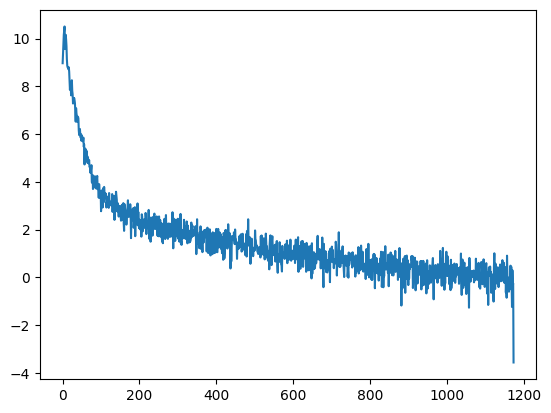

In [64]:
plt.plot(np.log(LP_loss),label='legendre')